# Training a Support vector Machine (SVM) and a Random Forest (RF) for hyperspectral data classification

, Krkonoše mountains, Czechia.

Pavia city centre is a common benchmark for hyperspectral data classification and can be obtained from http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Pavia_Centre_and_University

Our dataset from Luční Hora is currently not publicly available, but we are working on providing it in the future.

## Structure of this exercise

What are you going to encounter during this exercise.

0. Load libraries, set paths
1. Load and Preprocess training data
2. Create/Fit Classifiers  
    2.A Create/Fit Support Vector Machine  
    2.B Create/Fit Random Forest
3. Apply/Evaluate Classifier
4. Sample Result

## 0. Load external libraries and set paths to training data

First, we need to import external libraries:

- __numpy__ - Arrays to hold our data
- __matplotlib.pyplot__ - Draw images
- __sklearn.model_selection__ - Cross-validation implemented in scikit-learn
- __time.perf_counter__ - Track how long individual functions take to run
- __os.path__ - Path manipulation
- __tqdm__ - show progress bars during training

- __image_preprocessing__ - Our library holding functions for image tiling, preprocessing, etc.
- __inference_utils__ - Our library for correctly exporting classifed images
- __visualisation_utils__ - Our library for visualising the data

Two external libraries are not imported directly in this notebook, but are used by functions in _image_preprocessing_ and _inference_utils_:

- __gdal__ - Manipulates spatial data
- __scipy.io__ - Reads .mat files

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter
from os.path import join
import scipy

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import notebook as tqdm
from joblib import dump, load

import image_preprocessing
import inference_utils
import visualisation_utils

# GLOBAL SETTINGS
plt.rcParams['figure.figsize'] = [5, 5]
np.set_printoptions(precision=2, suppress=True)  # Array print precision

In [2]:
# PATHS TO TRAINING DATA
imagerydata_path =  'f:/datasets/etrainee/LH_202008_54bands_9cm.tif'
traindata_path = 'f:/datasets/etrainee/LH_202008_train.tif'

## 1. Load and preprocess training data

### 1.1 Load data into NumPy
In order to use 

In [3]:
loaded_raster = image_preprocessing.read_gdal(imagerydata_path, traindata_path)

print(f'Tiled imagery shape {loaded_raster["imagery"].shape}')
print(f'Tiled reference shape {loaded_raster["reference"].shape}')

Tiled imagery shape (1112, 1112, 54)
Tiled reference shape (1112, 1112, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


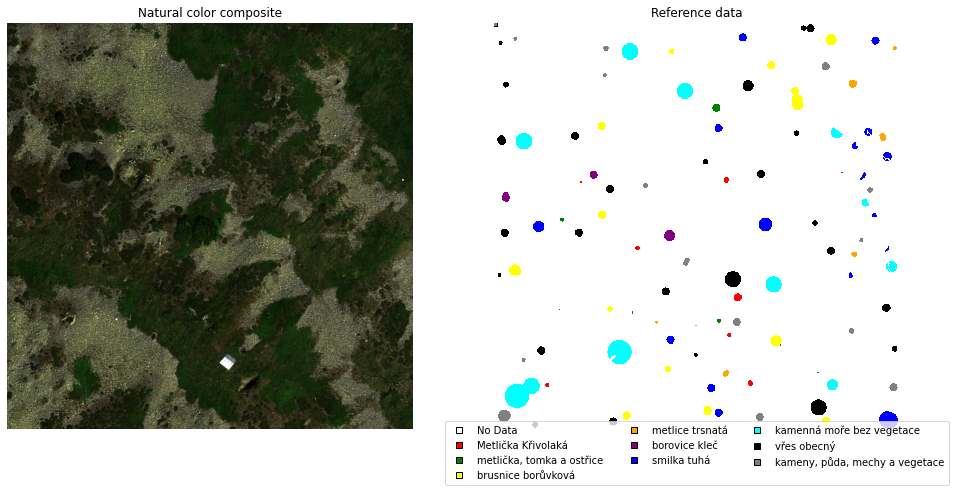

In [4]:
visualisation_utils.show_img_ref(loaded_raster["imagery"][:, :, [25, 15, 5]],
                                 loaded_raster["reference"], ds_name='krkonose')

### 1.2 Flatten array
We will be using SVM to classify individual pixels, therefore we can transform the 3D image (height, width, spectral bands) to a 2D array (length, spectral bands). This transformation destroys spatial relationships within the image, however we were not using them anyway and it simplifies the next step (filtering NoData).

In [5]:
orig_shape = loaded_raster['imagery'].shape

flat_arrs = {}
flat_arrs['imagery'] = loaded_raster['imagery'].reshape(orig_shape[0]*orig_shape[1], orig_shape[2])
flat_arrs['reference'] = loaded_raster['reference'].reshape(orig_shape[0]*orig_shape[1])

print(f'The flat imagery array has shape {flat_arrs["imagery"].shape}')

The flat imagery array has shape (1236544, 54)


### 1.3 Filter out NoData pixels

We can only train the classifier on pixels with a reference value, therefore we remove all pixels belonging to class 0 (NoData). This operation reduces our training dataset from ~1.23 milion to ~50 thousand pixels. We then visualise the spectral curves of individual pixels.

In [6]:
filtered_arrs = {}
filtered_arrs['imagery'] = flat_arrs['imagery'][flat_arrs['reference'] > 0]
filtered_arrs['reference'] = flat_arrs['reference'][flat_arrs['reference'] > 0]

print(f'The filtered array has shape {filtered_arrs["imagery"].shape}')

The filtered array has shape (49842, 54)


krkonose
('No Data', 'Metlička Křivolaká', 'metlička, tomka a ostřice', 'brusnice borůvková', 'metlice trsnatá', 'borovice kleč', 'smilka tuhá', 'kamenná moře bez vegetace', 'vřes obecný', 'kameny, půda, mechy a vegetace')
8


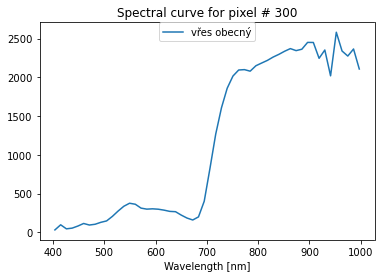

In [7]:
pixel_number = 300
visualisation_utils.show_spectral_curve(filtered_arrs, pixel_number, ds_name='krkonose')

### 1.4 Subsetting the training data
With the whole training dataset, the training procedure may take relatively long. Instead we randomly select a number of samples from each class for training.

In [8]:
# How many training samples do we have for each class?
unique, counts = np.unique(filtered_arrs['reference'], return_counts=True)
print(f'The individual classes contain {counts} training pixels.')

The individual classes contain [ 1113   638  6780  1316  1554  7543 16924 10158  3816] training pixels.


In [9]:
n_class_samples = 600
arr = np.zeros((n_class_samples*len(unique)), dtype=np.uint32)
sorted_reference = np.argsort(filtered_arrs['reference'])
print(arr.shape)
print(sorted_reference.shape)

start = 0
for idx in range(len(counts)):
    """
    print(f'idx = {idx}')
    print('Indices in new array:')
    print(idx*n_class_samples)
    print((idx+1)*n_class_samples)
    print('Indices in sorted array:')
    print(start)
    print(start+counts[idx])"""
    
    arr[(idx*n_class_samples):((idx+1)*n_class_samples)] = np.random.choice(
        sorted_reference[start:(start+counts[idx])], size=n_class_samples, replace=False)
    start += counts[idx]

(5400,)
(49842,)


In [10]:
# Randomly select 500 training pixels from each class
subset_arrs = {}
subset_arrs['imagery'] = filtered_arrs['imagery'][arr, :]
subset_arrs['reference'] = filtered_arrs['reference'][arr]

In [11]:
unique, counts = np.unique(subset_arrs['reference'], return_counts=True)
print(f'The individual classes contain {counts} training pixels.')

The individual classes contain [600 600 600 600 600 600 600 600 600] training pixels.


In [12]:
subset_arrs['imagery'].shape

(5400, 54)

krkonose
('No Data', 'Metlička Křivolaká', 'metlička, tomka a ostřice', 'brusnice borůvková', 'metlice trsnatá', 'borovice kleč', 'smilka tuhá', 'kamenná moře bez vegetace', 'vřes obecný', 'kameny, půda, mechy a vegetace')
1


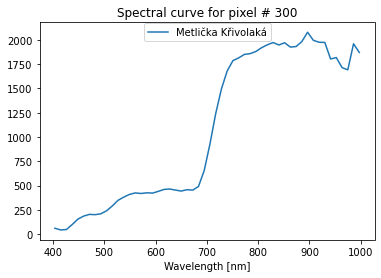

In [13]:
pixel_number = 300
visualisation_utils.show_spectral_curve(subset_arrs, pixel_number, ds_name='krkonose')

### 1.5 Data scaling
After filtering the training data, we can move onto data scaling. In Machine Learning, it is common to scale all features before classification, because many classifiers assume that all features vary on comparable scales  and that each feature has values close to zero.

In [14]:
preprocessed_arrs = {}
scaler = StandardScaler()
scaler.fit(flat_arrs['imagery'])
preprocessed_arrs['imagery'] = scaler.transform(subset_arrs['imagery'])
preprocessed_arrs['reference'] = subset_arrs['reference']

krkonose
('No Data', 'Metlička Křivolaká', 'metlička, tomka a ostřice', 'brusnice borůvková', 'metlice trsnatá', 'borovice kleč', 'smilka tuhá', 'kamenná moře bez vegetace', 'vřes obecný', 'kameny, půda, mechy a vegetace')
1


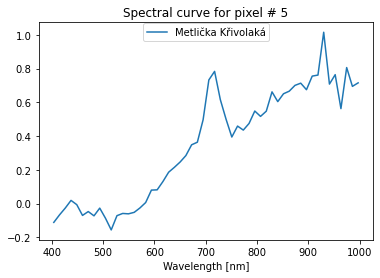

In [15]:
pixel_number = 5
visualisation_utils.show_spectral_curve(preprocessed_arrs, pixel_number, ds_name='krkonose')

## 2.A Support Vector Machine definition and training

This training uses a support vector machine implementation from scikit-learn, a popular Machine Learning library for Python. The documentation is available at [https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

### 2.1 Find most suitable parameters
Try different values for SVM hyperparameters, namely kernel, degree, C and gamma. Each version of hyperparameters is tried multiple times using cross-validation (out-of-sample testing).

In [ ]:
# define potential parameter values for the SVM
parameters_svm = {
    'class_weight': ['balanced'],            # 'balanced' sets weights based on the number of samples in each class
    'kernel': ['poly', 'rbf'],     # Define the kernel function
    'degree': [2, 3],                     # Degree of polynomial used for the 'poly' kernel
    'C': [0.1, 1, 10, 100, 1000, 10000],     # Define the penalty value
    'gamma': [.00001, .0001, .001, .01, .1], # Kernel parameter
}

In [ ]:
# Create the optimizer and run the optimization
opt = RandomizedSearchCV(SVC(), parameters_svm, cv=5, scoring="jaccard_micro", n_iter=8, refit=False, verbose=4, n_jobs=-2)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

In [ ]:
# Create the optimizer and run the optimization
opt = GridSearchCV(SVC(), parameters_svm, cv=5, scoring="jaccard_micro", refit=False, verbose=4, n_jobs=-2)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

### 2.2 Fit
The best hyperparameter values identified during corss-validation are then used for training the model on the whole training dataset.

In [ ]:
svm = SVC(**opt.best_params_)

svm.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])

### 2.3 Save/load trained model for potential future use

In [ ]:
# save using joblib.dump(object, filename)
dump(svm, 'c:/users/dd/documents/NATUR_CUNI/etrainee/svm.joblib')

In [ ]:
# load using joblib.load(filename)
svm = load('c:/users/dd/documents/NATUR_CUNI/etrainee/svm.joblib')

## 2.B Random Forest definition and training

This training uses a Random Forest implementation from scikit-learn, a popular Machine Learning library for Python. The documentation is available at [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### 2.1 Find most suitable parameters
Try differnt values for SVM hyperparameters, namely kernel, degree, C and gamma. Each version of hyperparameters is tried multiple times using cross-validation (out-of-sample testing).

In [16]:
# define potential parameter values for the SVM
parameters_rf = {
    'n_estimators': [50, 100, 250, 500, 750], # Number of trees in the forest
    'max_depth': [3, 5, 10, 20, 50],          # Maximum depth of a tree
}

In [18]:
# Create the optimizer and run the optimization
opt = RandomizedSearchCV(RandomForestClassifier(), parameters_rf, cv=5, scoring="jaccard_macro", n_iter=8, refit=False, n_jobs=-2, verbose=4)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   59.9s


The optimisation process identified these parameters as the most suitable: {'n_estimators': 750, 'max_depth': 50}


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:  1.8min finished


In [19]:
# Create the optimizer and run the optimization
opt = GridSearchCV(RandomForestClassifier(), parameters_rf, cv=5, scoring="jaccard_micro", refit=False, n_jobs=-2, verbose=4)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-2)]: Done  92 tasks      | elapsed:  3.1min


The optimisation process identified these parameters as the most suitable: {'max_depth': 50, 'n_estimators': 500}


[Parallel(n_jobs=-2)]: Done 125 out of 125 | elapsed:  5.5min finished


### 2.2 Fit
The best hyperparameter values identified during corss-validation are then used for training the model on the whole training dataset.

In [22]:
rf = RandomForestClassifier(**opt.best_params_)

rf.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
rf.score(preprocessed_arrs['imagery'], preprocessed_arrs['reference'])

1.0

### 2.3 Save/load trained model for potential future use

In [ ]:
# save using joblib.dump(object, filename)
dump(rf, 'c:/users/dd/documents/NATUR_CUNI/etrainee/rf.joblib')

In [ ]:
# load using joblib.load(filename)
rf = load('c:/users/dd/documents/NATUR_CUNI/etrainee/rf.joblib')

## 3. Model application & evaluation

### 3.1 Load data and apply model

In [23]:
model = rf
#model = svm

In [24]:
raster_path = imagerydata_path
raster = image_preprocessing.read_gdal_with_geoinfo(raster_path, (0,0))

raster_shape = raster['imagery'].shape
raster_flat = raster['imagery'].reshape(raster_shape[0]*raster_shape[1], raster_shape[2])

scaler = StandardScaler()
scaler.fit(raster_flat)
raster_scaled = scaler.transform(raster_flat)

In [25]:
predicted_flat = model.predict(raster_scaled)
#predicted_flat = model.predict(raster_flat)

In [26]:
predicted_raster = predicted_flat.reshape(raster_shape[0], raster_shape[1])

### 3.2 View / Export resulting raster

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


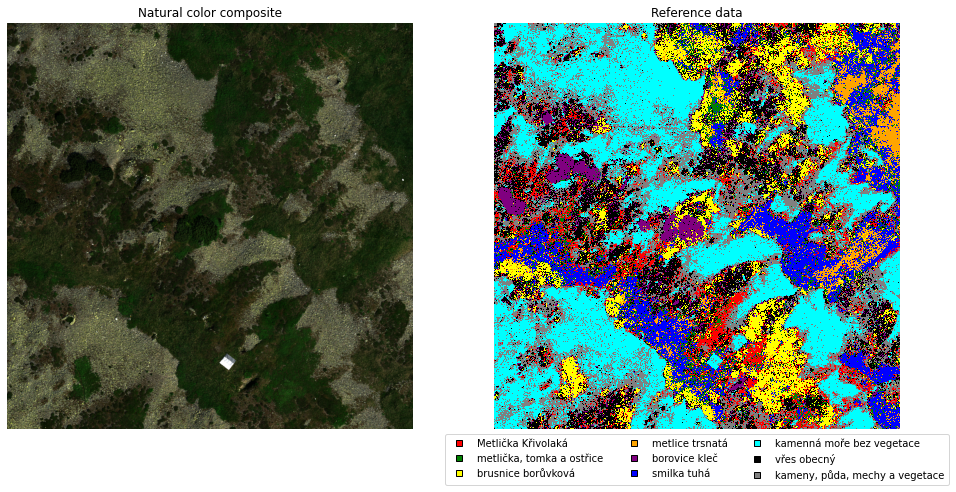

In [27]:
visualisation_utils.show_img_ref(loaded_raster["imagery"][:, :, [25, 15, 5]],
                                 predicted_raster, ds_name='krkonose')

In [ ]:
out_path = 'c:/users/dd/documents/NATUR_CUNI/etrainee/svm.tif'
inference_utils.export_result(out_path, predicted_raster, raster['geoinfo'])

In [46]:
lst = [1113, 638, 6780, 1316, 1554, 7543, 16924, 10158, 3816]
suma = sum(lst)
weights = [suma/(i) for i in lst]
weights = [j/sum(weights) for j in weights]
weights

[0.1966495481867119,
 0.3430579108649065,
 0.03228185060941156,
 0.16631530937067657,
 0.1408435953229153,
 0.029016432073685587,
 0.012932577826270998,
 0.021546657524297144,
 0.057356118221124304]

### 3.2 Load test raster
Load raster with test data and flatten it

In [28]:
testdata_path = 'f:/datasets/etrainee/LH_202008_test.tif'

In [29]:
test_arr = image_preprocessing.read_gdal(imagerydata_path, testdata_path)
test_flat = test_arr['reference'].reshape(test_arr['reference'].shape[0] * test_arr['reference'].shape[1])

In [30]:
predicted_filtered = predicted_flat[test_flat > 0]
test_filtered = test_flat[test_flat > 0]

(array([ 5487.,  2865., 11256.,  4043.,     0.,  4827., 12152., 32810.,
        16658., 11261.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

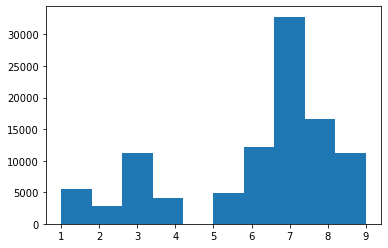

In [31]:
plt.hist(predicted_filtered)

(array([ 2141.,  1271., 12532.,  2533.,     0.,  3052., 15964., 34622.,
        20668.,  8576.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

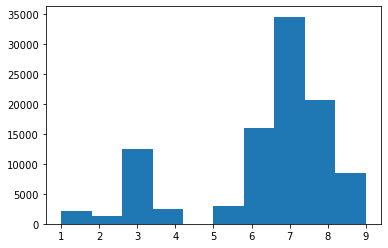

In [32]:
plt.hist(test_filtered)

### 3.3 Compute accuracy metrics

In [33]:
class_names = ('No Data', 'metlička křivolaká',
            'metlička, tomka a ostřice',
            'brusnice borůvková', 'metlice trsnatá',
            'borovice kleč', 'smilka tuhá', 'kamenná moře bez vegetace',
            'vřes obecný', 'kameny, půda, mechy a vegetace')

In [34]:
class_names[1:]

('metlička křivolaká',
 'metlička, tomka a ostřice',
 'brusnice borůvková',
 'metlice trsnatá',
 'borovice kleč',
 'smilka tuhá',
 'kamenná moře bez vegetace',
 'vřes obecný',
 'kameny, půda, mechy a vegetace')

In [35]:
print(classification_report(test_filtered, predicted_filtered))#, labels=class_names[1:]))

              precision    recall  f1-score   support

           1       0.20      0.52      0.29      2141
           2       0.04      0.08      0.05      1271
           3       0.83      0.74      0.78     12532
           4       0.48      0.76      0.59      2533
           5       0.56      0.89      0.69      3052
           6       0.93      0.71      0.80     15964
           7       0.95      0.90      0.93     34622
           8       0.84      0.68      0.75     20668
           9       0.50      0.65      0.56      8576

    accuracy                           0.76    101359
   macro avg       0.59      0.66      0.61    101359
weighted avg       0.82      0.76      0.78    101359



In [36]:
conf_matrix = confusion_matrix(test_filtered, predicted_filtered)

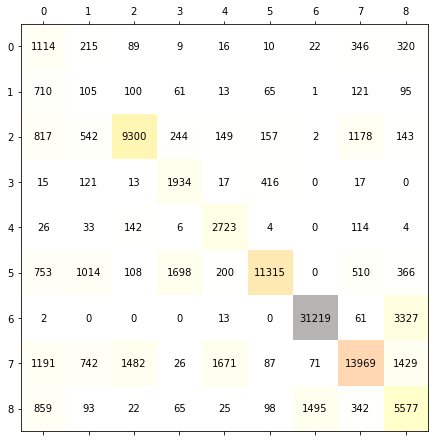

In [37]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.hot_r, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

## 4. Sample Result

Following classifications were performed using SVM with the RBF kernel, gamma=0.1, C=100 and RF with 500 trees.